# LSTM  + ElMO



In [1]:
import pandas as pd
import csv
import numpy as np
import tensorflow as tf
import random
import torch

seed = 

torch.manual_seed(2019)
np.random.seed(2019)
tf.random.set_random_seed(2019)
random.seed(2019)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

df_dev = pd.read_table("../../../data/es/dev_es.tsv", index_col="id", quoting=csv.QUOTE_NONE)
df_train = pd.read_table("../../../data/es/train_es.tsv", index_col="id", quoting=csv.QUOTE_NONE)
df_test = pd.read_table("../../../data/es/reference_es.tsv", header=None, 
                        names=["text", "HS", "TR", "AG"], quoting=csv.QUOTE_NONE)


text_train, y_train = df_train["text"], df_train["HS"]
text_dev, y_dev = df_dev["text"], df_dev["HS"]
text_test, y_test = df_test["text"], df_test["HS"]

print("Instancias de entrenamiento: {}".format(len(df_train)))
print("Instancias de desarrollo: {}".format(len(df_dev)))
print("Instancias de test: {}".format(len(df_test)))


Instancias de entrenamiento: 4500
Instancias de desarrollo: 500
Instancias de test: 1600


Tengo que hacer dos cosas:

- Primero, convertir los tweets a secuencias de texto
- Luego, paddear las secuencias a cierta longitud (Keras necesita esto para poder paralelizar cálculo)

In [2]:
from nltk.tokenize import TweetTokenizer
from keras.preprocessing.sequence import pad_sequences


max_length = 30

tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)

def preprocess_tweet(tweet):
    tokens = tokenizer.tokenize(tweet)
    
    if len(tokens) >= max_length:
        tokens = tokens[:max_length]
    else:
        tokens = tokens + [''] * (max_length - len(tokens))
    return tokens


text_train = [preprocess_tweet(tweet) for tweet in df_train["text"].values]
text_dev = [preprocess_tweet(tweet) for tweet in df_dev["text"].values]
text_test = [preprocess_tweet(tweet) for tweet in df_test["text"].values]

Using TensorFlow backend.


In [3]:
%%capture
from elmoformanylangs import Embedder

e = Embedder("../../../models/elmo/es/")

Carguemos embeddings

In [4]:
import numpy as np

print(text_train[0])


X_train = np.array(e.sents2elmo(text_train))
X_dev = np.array(e.sents2elmo(text_dev))
X_test = np.array(e.sents2elmo(text_test))

['easyjet', 'quiere', 'duplicar', 'el', 'número', 'de', 'mujeres', 'piloto', "'", 'verás', 'tú', 'para', 'aparcar', 'el', 'avión', '..', 'http://t.co/46NuLkm09x', '', '', '', '', '', '', '', '', '', '', '', '', '']


In [5]:
X_train.shape, X_dev.shape, X_test.shape, y_train.shape, y_dev.shape, y_test.shape

((4500, 30, 1024), (500, 30, 1024), (1600, 30, 1024), (4500,), (500,), (1600,))

In [22]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, CuDNNLSTM
from keras.optimizers import Adam
from keras.preprocessing import sequence

embedding_dim = 1024

optimizer_args = {
    "lr": 0.002,
    "decay": 0.01
}

model = Sequential()
model.add(CuDNNGRU(256, input_shape=(max_length, embedding_dim)))
model.add(Dropout(0.80))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.55))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer=Adam(**optimizer_args), 
              metrics=['accuracy'])
print(model.summary())

model.fit(X_train, y_train, validation_data=(X_dev, y_dev), epochs=30, batch_size=32)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_4 (CuDNNGRU)       (None, 256)               984576    
_________________________________________________________________
dropout_19 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_20 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 257       
Total params: 1,050,625
Trainable params: 1,050,625
Non-trainable params: 0
_________________________________________________________________
None
Train on 4500 samples, validate on 500 samples
Epoch 1/30
4500/4500 [==============================] - 3s 591us/step - loss: 0.

In [23]:
from hate.utils import print_evaluation
print("GRU-LSTM -- \n\n")
print("Evaluación sobre dev")
print_evaluation(model, X_dev, y_dev)
print("\n\nEvaluación sobre test")
print_evaluation(model, X_test, y_test)



GRU-LSTM -- 


Evaluación sobre dev
500/500 [==============================] - 0s 183us/step
Loss           : 0.4675
Accuracy       : 0.8080
Precision(1)   : 0.7864
Precision(1)   : 0.8250
Precision(avg) : 0.8057

Recall(1)      : 0.7793
Recall(0)      : 0.8309
Recall(avg)    : 0.8051

F1(1)          : 0.7828
F1(0)          : 0.8280
F1(avg)        : 0.8054


Evaluación sobre test
1600/1600 [==============================] - 0s 156us/step
Loss           : 0.7042
Accuracy       : 0.7288
Precision(1)   : 0.6544
Precision(1)   : 0.7915
Precision(avg) : 0.7229

Recall(1)      : 0.7258
Recall(0)      : 0.7309
Recall(avg)    : 0.7283

F1(1)          : 0.6882
F1(0)          : 0.7600
F1(avg)        : 0.7241


## Bidirectional GRU

In [24]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import CuDNNGRU, Dropout, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.optimizers import Adam

optimizer_args = {
    "lr": 0.001,
    "decay": 0.01
}

embedding_dim = 1024

model = Sequential()
model.add(Bidirectional(CuDNNGRU(256), input_shape=(max_length, embedding_dim)))
model.add(Dropout(0.80))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.55))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer=Adam(**optimizer_args), 
              metrics=['accuracy'])

model.fit(X_train, y_train.values, validation_data=(X_dev, y_dev), epochs=25, batch_size=32)


Train on 4500 samples, validate on 500 samples
Epoch 1/25
4500/4500 [==============================] - 3s 745us/step - loss: 0.8857 - acc: 0.5413 - val_loss: 0.6754 - val_acc: 0.5780
Epoch 2/25
4500/4500 [==============================] - 2s 434us/step - loss: 0.7046 - acc: 0.5896 - val_loss: 0.6659 - val_acc: 0.5820
Epoch 3/25
4500/4500 [==============================] - 2s 433us/step - loss: 0.6617 - acc: 0.6324 - val_loss: 0.6553 - val_acc: 0.6300
Epoch 4/25
4500/4500 [==============================] - 2s 443us/step - loss: 0.6209 - acc: 0.6591 - val_loss: 0.6208 - val_acc: 0.7220
Epoch 5/25
4500/4500 [==============================] - 2s 438us/step - loss: 0.5852 - acc: 0.6969 - val_loss: 0.5880 - val_acc: 0.7340
Epoch 6/25
4500/4500 [==============================] - 2s 436us/step - loss: 0.5510 - acc: 0.7229 - val_loss: 0.5588 - val_acc: 0.7680
Epoch 7/25
4500/4500 [==============================] - 2s 434us/step - loss: 0.5136 - acc: 0.7493 - val_loss: 0.5409 - val_acc: 0.7780
E

In [25]:
from hate.utils import print_evaluation
print("biGRU-ELMO \n\n")
print("Evaluación sobre dev")
print_evaluation(model, X_dev, y_dev)
print("\n\nEvaluación sobre test")
print_evaluation(model, X_test, y_test)



biGRU-ELMO 


Evaluación sobre dev
500/500 [==============================] - 0s 229us/step
Loss           : 0.4307
Accuracy       : 0.8080
Precision(1)   : 0.8088
Precision(1)   : 0.8074
Precision(avg) : 0.8081

Recall(1)      : 0.7432
Recall(0)      : 0.8597
Recall(avg)    : 0.8015

F1(1)          : 0.7746
F1(0)          : 0.8328
F1(avg)        : 0.8037


Evaluación sobre test
1600/1600 [==============================] - 0s 201us/step
Loss           : 0.5458
Accuracy       : 0.7312
Precision(1)   : 0.6764
Precision(1)   : 0.7690
Precision(avg) : 0.7227

Recall(1)      : 0.6682
Recall(0)      : 0.7755
Recall(avg)    : 0.7219

F1(1)          : 0.6723
F1(0)          : 0.7722
F1(avg)        : 0.7223


## Bidirectional LSTM



In [13]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import CuDNNGRU, Dropout, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.optimizers import Adam

optimizer_args = {
    "lr": 0.0005,
    "decay": 0.01
}

embedding_dim = 1024

model = Sequential()
model.add(Bidirectional(CuDNNLSTM(256), input_shape=(max_length, embedding_dim)))
model.add(Dropout(0.80))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.55))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer=Adam(**optimizer_args), 
              metrics=['accuracy'])

model.fit(X_train, y_train.values, validation_data=(X_dev, y_dev), epochs=25, batch_size=32)


Train on 4500 samples, validate on 500 samples
Epoch 1/25
4500/4500 [==============================] - 3s 664us/step - loss: 0.7385 - acc: 0.5640 - val_loss: 0.6666 - val_acc: 0.5880
Epoch 2/25
4500/4500 [==============================] - 2s 460us/step - loss: 0.6634 - acc: 0.6178 - val_loss: 0.6468 - val_acc: 0.6320
Epoch 3/25
4500/4500 [==============================] - 2s 462us/step - loss: 0.6425 - acc: 0.6409 - val_loss: 0.6236 - val_acc: 0.6560
Epoch 4/25
4500/4500 [==============================] - 2s 461us/step - loss: 0.6086 - acc: 0.6742 - val_loss: 0.5996 - val_acc: 0.6860
Epoch 5/25
4500/4500 [==============================] - 2s 456us/step - loss: 0.5883 - acc: 0.7013 - val_loss: 0.5751 - val_acc: 0.6960
Epoch 6/25
4500/4500 [==============================] - 2s 467us/step - loss: 0.5638 - acc: 0.7251 - val_loss: 0.5552 - val_acc: 0.7300
Epoch 7/25
4500/4500 [==============================] - 2s 456us/step - loss: 0.5381 - acc: 0.7351 - val_loss: 0.5345 - val_acc: 0.7480
E

In [14]:
model.fit(X_train, y_train.values, validation_data=(X_dev, y_dev), epochs=10, batch_size=32)


Train on 4500 samples, validate on 500 samples
Epoch 1/10
4500/4500 [==============================] - 2s 468us/step - loss: 0.3495 - acc: 0.8500 - val_loss: 0.4565 - val_acc: 0.7960
Epoch 2/10
4500/4500 [==============================] - 2s 457us/step - loss: 0.3445 - acc: 0.8556 - val_loss: 0.4466 - val_acc: 0.7900
Epoch 3/10
4500/4500 [==============================] - 2s 462us/step - loss: 0.3314 - acc: 0.8596 - val_loss: 0.4486 - val_acc: 0.7920
Epoch 4/10
4500/4500 [==============================] - 2s 460us/step - loss: 0.3311 - acc: 0.8636 - val_loss: 0.4530 - val_acc: 0.7980
Epoch 5/10
4500/4500 [==============================] - 2s 464us/step - loss: 0.3253 - acc: 0.8609 - val_loss: 0.4565 - val_acc: 0.7900
Epoch 6/10
4500/4500 [==============================] - 2s 460us/step - loss: 0.3129 - acc: 0.8653 - val_loss: 0.4532 - val_acc: 0.7880
Epoch 7/10
4500/4500 [==============================] - 2s 456us/step - loss: 0.3186 - acc: 0.8680 - val_loss: 0.4589 - val_acc: 0.7900
E

In [15]:
from hate.utils import print_evaluation

print("Evaluación sobre dev")
print_evaluation(model, X_dev, y_dev)
print("\n\nEvaluación sobre test")
print_evaluation(model, X_test, y_test)


Evaluación sobre dev
500/500 [==============================] - 0s 211us/step
Loss           : 0.4617
Accuracy       : 0.7880
Precision(1)   : 0.7762
Precision(1)   : 0.7966
Precision(avg) : 0.7864

Recall(1)      : 0.7342
Recall(0)      : 0.8309
Recall(avg)    : 0.7826

F1(1)          : 0.7546
F1(0)          : 0.8134
F1(avg)        : 0.7840


Evaluación sobre test
1600/1600 [==============================] - 0s 203us/step
Loss           : 0.6203
Accuracy       : 0.7244
Precision(1)   : 0.6613
Precision(1)   : 0.7709
Precision(avg) : 0.7161

Recall(1)      : 0.6803
Recall(0)      : 0.7553
Recall(avg)    : 0.7178

F1(1)          : 0.6706
F1(0)          : 0.7630
F1(avg)        : 0.7168


# Bidirectional GRU sin densa

In [27]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import CuDNNGRU, Dropout, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.optimizers import Adam

optimizer_args = {
    "lr": 0.0005,
    "decay": 0.01
}

embedding_dim = 1024

model = Sequential()
model.add(Bidirectional(CuDNNGRU(256), input_shape=(max_length, embedding_dim)))
model.add(Dropout(0.80))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer=Adam(**optimizer_args), 
              metrics=['accuracy'])

model.fit(X_train, y_train.values, validation_data=(X_dev, y_dev), epochs=25, batch_size=32)



Train on 4500 samples, validate on 500 samples
Epoch 1/25
4500/4500 [==============================] - 4s 823us/step - loss: 0.8033 - acc: 0.5889 - val_loss: 0.6358 - val_acc: 0.6680
Epoch 2/25
4500/4500 [==============================] - 2s 439us/step - loss: 0.6520 - acc: 0.6633 - val_loss: 0.5888 - val_acc: 0.6960
Epoch 3/25
4500/4500 [==============================] - 2s 438us/step - loss: 0.5620 - acc: 0.7253 - val_loss: 0.5371 - val_acc: 0.7340
Epoch 4/25
4500/4500 [==============================] - 2s 433us/step - loss: 0.5035 - acc: 0.7580 - val_loss: 0.4944 - val_acc: 0.7560
Epoch 5/25
4500/4500 [==============================] - 2s 436us/step - loss: 0.4556 - acc: 0.7840 - val_loss: 0.4726 - val_acc: 0.7860
Epoch 6/25
4500/4500 [==============================] - 2s 432us/step - loss: 0.4297 - acc: 0.8042 - val_loss: 0.4579 - val_acc: 0.7900
Epoch 7/25
4500/4500 [==============================] - 2s 434us/step - loss: 0.4081 - acc: 0.8160 - val_loss: 0.4557 - val_acc: 0.7920
E

In [28]:
from hate.utils import print_evaluation

print("Evaluación sobre dev")
print_evaluation(model, X_dev, y_dev)
print("\n\nEvaluación sobre test")
print_evaluation(model, X_test, y_test)


Evaluación sobre dev
500/500 [==============================] - 0s 227us/step
Loss           : 0.4689
Accuracy       : 0.7920
Precision(1)   : 0.7682
Precision(1)   : 0.8107
Precision(avg) : 0.7894

Recall(1)      : 0.7613
Recall(0)      : 0.8165
Recall(avg)    : 0.7889

F1(1)          : 0.7647
F1(0)          : 0.8136
F1(avg)        : 0.7892


Evaluación sobre test
1600/1600 [==============================] - 0s 201us/step
Loss           : 0.6708
Accuracy       : 0.7275
Precision(1)   : 0.6530
Precision(1)   : 0.7903
Precision(avg) : 0.7217

Recall(1)      : 0.7242
Recall(0)      : 0.7298
Recall(avg)    : 0.7270

F1(1)          : 0.6868
F1(0)          : 0.7588
F1(avg)        : 0.7228


## Error Analysis

Vamos a ver los tweets con mayores errores

In [21]:
df_dev["proba"] = model.predict_proba(X_dev)


true_positives = df_dev[(df_dev["HS"] == 1) & (df_dev["proba"] >= 0.5)].copy()
true_negatives = df_dev[(df_dev["HS"] == 0) & (df_dev["proba"] < 0.5)].copy()

false_positives = df_dev[(df_dev["HS"] == 0) & (df_dev["proba"] > 0.5)].copy()
false_positives.sort_values("proba", ascending=False, inplace=True)


false_negatives = df_dev[(df_dev["HS"] == 1) & (df_dev["proba"] < 0.5)].copy()
false_negatives.sort_values("proba", ascending=True, inplace=True)

conf_matrix = pd.DataFrame([
    {"real":"hs=1", "pred_true": len(true_positives), "pred_false": len(false_negatives)},
    {"real":"hs=0", "pred_true": len(false_positives), "pred_false": len(true_negatives)}
])



conf_matrix.set_index("real", inplace=True)

conf_matrix[["pred_true", "pred_false"]]

,pred_true,pred_false
real,,
hs=1,175,47
hs=0,53,225


## Falsos Negativos

Veamos los 20 falsos negativos en los cuales nuestro modelo se equivoca más

In [29]:
false_negatives.iloc[:20]


,text,HS,TR,AG,proba
id,,,,,
21535,#VOX critica duramente a ⁦@pablocasado_⁩ “Les da la bienvenida como si fuera un cartel del welcome de #Carmena “ ¡Expulsión inmediata de moromierdas! https://t.co/HaySDibj2l,1,0,1,0.043542
21152,@NatyBurgos15 @Horaciogenta @PaolaPa05 Cállate vos Black and bitch como la puta falsa abogada. Espero se pudra en la cárcel y devuelva todo. Dedícate a estudiar en serio. La droga es mala. Cristin...,1,1,1,0.053808
22560,@CarlaEUrena @FelipeCalderon Callateeeee !! Puta gallina cacarea !! Ni idea tienes de nada .,1,1,1,0.080199
23415,Exacto! #puralata #feminazis #HombreAbusado https://t.co/zTEvaftxcd,1,0,1,0.084722
21215,"Que tal otro aporte anónimo son de la puta de mi esposa, así los dejó en navidad enseñando le los calzones al vecino rt y siguenos @TANGASUCIA @Tangasrobadas https://t.co/70ioUjveqY",1,1,1,0.092792
24925,"La verdad que si, no veia la hora de llegar a los 5 mil amigos😂 ahora de a poco voy borrando esos indios indocumentados😂 https://t.co/Xw8q4GLM8v",1,0,0,0.144993
24401,No habrá que darles de lo 'nuestro'. Ellos se apropiarán de lo 'suyo'. @Manuj_Hidalgo les dice ☝️ a quienes piensan q hay q jubilar a los mayores para q trabajen los jóvenes o q los q vienen d fu...,1,0,1,0.151047
21072,"Voy andando por la calle y me han dicho cosas en árabe ya que me estas acosando dime lo en español para que te entienda, asique como yo no les entiendo me he cagado en su puta madre en árabe para ...",1,0,1,0.152465
24590,"SOMOS MUCHO MÁS DE LO QUE SUEÑAS SER PINCHÉ SUDACA CAGADO, y si no te gusta dime donde nos topamos pa reventarnos el hocico 1:1 @amarchesin1 https://t.co/vHHPBKS1AK",1,1,1,0.157015


- Qué onda la longitud de la secuencia?


(array([ 734., 1109., 1019.,  655.,  386.,  315.,  210.,   57.,   13.,
           2.]),
 array([ 2., 10., 18., 26., 34., 42., 50., 58., 66., 74., 82.]),
 <a list of 10 Patch objects>)

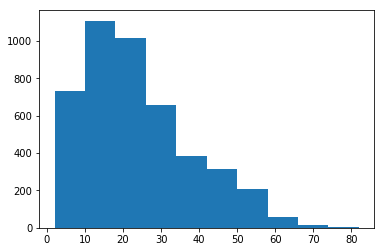

In [39]:
import matplotlib.pyplot as plt

tokens_dev = df_dev["text"].apply(lambda t: len(tokenizer.tokenize(t)))
tokens_train = df_train["text"].apply(lambda t: len(tokenizer.tokenize(t)))

plt.hist(tokens_train)

In [28]:
pd.set_option('max_colwidth', 200)
false_positives.iloc[:20]

,text,HS,TR,AG,proba
id,,,,,
22517,"-¿eres poblana? -soy colombiana -¿y por qué eres güera? en Colombia TODAS son morenas, fui a Colombia 3 veces. -ok, mentí 🙄 solo me pinto el cabello",0,0,0,0.971048
22416,@Pepe_ElEzequiel Puta!? Puta con las que vos te metes Esa mujer es un ángel enviado por Jesucristo nuestro señor para darnos esa paz que buscamos sólo con verla,0,0,0,0.967200
21892,@saancisco Callate puta tu eres el traidor.,0,0,0,0.963039
21497,Talvez quede como zorra pero te lo mereces Socia😎,0,0,0,0.947185
24172,"Y los que no se denuncian... hagamos números. El acoso a las mujeres es diario. No todos los hombres son acosadores, pero todas las mujeres han sido acosadas. https://t.co/jza9llhqWA",0,0,0,0.945128
21255,Y tú eres una maldita escoria con una repugnante inclinación por los hombres.. ¡Seres como tú me producen náuseas! https://t.co/TaHDcpZdnm,0,0,0,0.943286
24159,"@LeonDeJapon Jajajajajaja tu eres uno, diego jajajajajaja mentira perra perra perrraaaaaaaaaa de mierda jajaja ♡",0,0,0,0.931898
24402,zorra eres tu que no te sientes hombre y no entiendes que toda mujer es bella,0,0,0,0.925799
21671,"@danlntifada @fatinascidi @manolivizoso @Zurine3 @Jvillaver2 https://t.co/HG4ljNlwR3, coño entonces tu eres de lo que te guias por el antes de cristo y despues de cristo,cuando llegamos los Españo...",0,0,0,0.921038


['easyjet',
 'quiere',
 'duplicar',
 'el',
 'número',
 'de',
 'mujeres',
 'piloto',
 "'",
 'verás',
 'tú',
 'para',
 'aparcar',
 'el',
 'avión',
 '..',
 'http://t.co/46NuLkm09x',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '']